In [2]:
! pip install -qq tensorflow tensorflow_addons

In [3]:
! pip install xgboost
! pip install imbalanced-learn
! pip install --upgrade scikit-learn
! pip uninstall imbalanced-learn --y
! pip install imbalanced-learn

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/ee/2c/03d466d00818c8e0ffcf778946ca4a5e05694a11b85bc51f1bc5c18ca54e/xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata
  Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl (297.1 MB)

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
  Obtaining dependency information for scikit-learn>=1.0.2 from https://files.pythonhosted.org/packages/d0/0b/26ad95cf0b747be967b15fb71a06f5ac67aba0fd2f9cd174de6edefc4674/scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.many

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE

import tensorflow_addons as tfa

# Load data
data = pd.read_csv('fraudTrain.csv')
data = data[:50000]

2023-10-26 08:02:10.685343: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 08:02:10.726232: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 08:02:10.726271: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 08:02:10.726295: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 08:02:10.733546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 08:02:10.734247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [4]:
data['is_fraud'].value_counts()

0.0    49552
1.0      448
Name: is_fraud, dtype: int64

In [5]:
data.shape

(50000, 23)

In [8]:
(448/50000)*100 # highly imbalanced target class

0.8959999999999999

<AxesSubplot:xlabel='is_fraud', ylabel='count'>

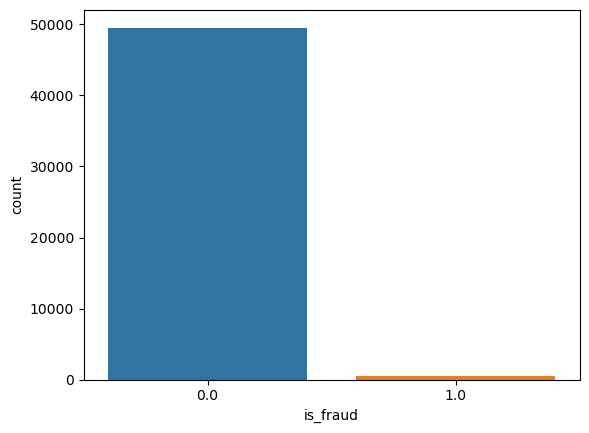

In [10]:
import seaborn as sns

sns.countplot(x = data['is_fraud'])

In [11]:
data.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [12]:
data = data.drop('Unnamed: 0',axis=1)
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0


In [13]:
df = data.copy()
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0


In [14]:
#  Converting data type of trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df.dtypes['trans_date_trans_time']

# Derive 'Transaction Hour' Feature from 'Transaction Time' Feature
df['time'] = df['trans_date_trans_time'].dt.strftime('%H:%M:%S')
df['time']

# Derive 'Day of Week' Feature from 'Transaction Time' Feature
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
df['day_of_week']

# Derive 'month - year' feature
df['Month']  = pd.DatetimeIndex(df['trans_date_trans_time']).month
df['Year'] = pd.DatetimeIndex(df['trans_date_trans_time']).year

# Convert 'DOB' to datetime if it's not already
df['dob'] = pd.to_datetime(df['dob'])
# Calculate age
current_date = pd.Timestamp('now')
df['age'] = current_date.year - df['dob'].dt.year

# Sort the DataFrame by the "age" column in ascending order
df.sort_values(by='age')

df['age']

# Define the age groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20','21-40','41-60', '61-80', '81-100']

# Use the cut function to create the age_group feature
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

# Display the DataFrame with the new age_group feature
df['age_group']

# Convert 'DOB' to datetime if it's not already
df['dob'] = pd.to_datetime(df['dob'])
# Calculate age
current_date = pd.Timestamp('now')
df['age'] = current_date.year - df['dob'].dt.year

# Sort the DataFrame by the "age" column in ascending order
df.sort_values(by='age')

df['age']

# Define the age groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20','21-40','41-60', '61-80', '81-100']

# Use the cut function to create the age_group feature
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

# Display the DataFrame with the new age_group feature
df['age_group']

0         21-40
1         41-60
2         61-80
3         41-60
4         21-40
          ...  
49995    81-100
49996     61-80
49997     21-40
49998     41-60
49999     21-40
Name: age_group, Length: 50000, dtype: category
Categories (5, object): ['0-20' < '21-40' < '41-60' < '61-80' < '81-100']

In [15]:
# Convert categorical column gender into numerical 
df.gender=df.gender.apply(lambda x: 1 if x=="M" else 0)

In [16]:
columns_to_drop = ['cc_num','merchant','trans_date_trans_time','city','lat','long','job','dob','merch_lat','merch_long']

# Use the drop method to remove the specified columns
df = df.drop(columns=columns_to_drop)

In [17]:
columns_drop = ['trans_num','unix_time','first','last','street','zip','age_group','day_of_week', 'state','time']

# Use the drop method to remove the specified columns
df = df.drop(columns=columns_drop)

In [18]:
df = pd.get_dummies(df, columns=['category'], prefix='category')

df = df.reindex(columns=df.columns, fill_value=0)

In [19]:
# Convert categorical column gender into numerical 
df['category_entertainment']=df['category_entertainment'].astype(int)

df['category_kids_pets']=df['category_kids_pets'].astype(int)

df['category_shopping_pos']=df['category_shopping_pos'].astype(int)

df['category_travel']=df['category_travel'].astype(int)

df['category_health_fitness']=df['category_health_fitness'].astype(int)

df['category_home']=df['category_home'].astype(int)

df['category_misc_pos']=df['category_misc_pos'].astype(int)

df['category_shopping_net']=df['category_shopping_net'].astype(int)

df['category_gas_transport']=df['category_gas_transport'].astype(int)

df['category_misc_net']=df['category_misc_net'].astype(int)

df['category_grocery_net']=df['category_grocery_net'].astype(int)

df['category_kids_pets']=df['category_kids_pets'].astype(int)

df['category_personal_care'] = df['category_personal_care'].astype(int)
 
df['category_grocery_pos'] = df['category_grocery_pos'].astype(int)

In [32]:
df.head(2)

,amt,gender,city_pop,is_fraud,Month,Year,age,category_entertainment,category_food_dining,category_gas_transport,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.97,0,3495.0,0.0,1,2019,35,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,107.23,0,149.0,0.0,1,2019,45,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [33]:
df.isnull().sum()

amt                        0
gender                     0
city_pop                   0
is_fraud                   0
Month                      0
Year                       0
age                        0
category_entertainment     0
category_food_dining       0
category_gas_transport     0
category_grocery_net       0
category_grocery_pos       0
category_health_fitness    0
category_home              0
category_kids_pets         0
category_misc_net          0
category_misc_pos          0
category_personal_care     0
category_shopping_net      0
category_shopping_pos      0
category_travel            0
dtype: int64

In [34]:
# Split the dataset into train and test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

In [36]:
train_data.isnull().sum(), test_data.isnull().sum()

(amt                        0
 gender                     0
 city_pop                   0
 is_fraud                   0
 Month                      0
 Year                       0
 age                        0
 category_entertainment     0
 category_food_dining       0
 category_gas_transport     0
 category_grocery_net       0
 category_grocery_pos       0
 category_health_fitness    0
 category_home              0
 category_kids_pets         0
 category_misc_net          0
 category_misc_pos          0
 category_personal_care     0
 category_shopping_net      0
 category_shopping_pos      0
 category_travel            0
 dtype: int64,
 amt                        0
 gender                     0
 city_pop                   0
 is_fraud                   0
 Month                      0
 Year                       0
 age                        0
 category_entertainment     0
 category_food_dining       0
 category_gas_transport     0
 category_grocery_net       0
 category_grocery_pos    

In [22]:
normalized_train=(train_data-train_data.min())/(train_data.max()-train_data.min())
normalized_test=(test_data-test_data.min())/(test_data.max()-test_data.min())

In [39]:
train_x = train_data.drop("is_fraud", axis=1).values
train_y = train_data["is_fraud"].values
test_x = test_data.drop("is_fraud", axis=1).values
test_y = test_data["is_fraud"].values

In [43]:
from sklearn.preprocessing import StandardScaler

# Fit on training data and transform both train and test data
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [44]:
train_x.shape, test_x.shape

((35000, 20), (15000, 20))

Epoch 1/20
274/274 [==============================] - 2s 3ms/step - loss: 0.9001 - val_loss: 0.9114
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 5/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 6/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 7/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 8/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 9/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 10/20
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83db527e20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Threshold: 2.634033402599041
Classification Report for the Ensemble Model:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     14870
         1.0       0.58      0.23      0.33       130

    accuracy                           0.99     15000
   macro avg       0.79      0.61      0.66     15000
weighted avg       0.99      0.99      0.99     15000



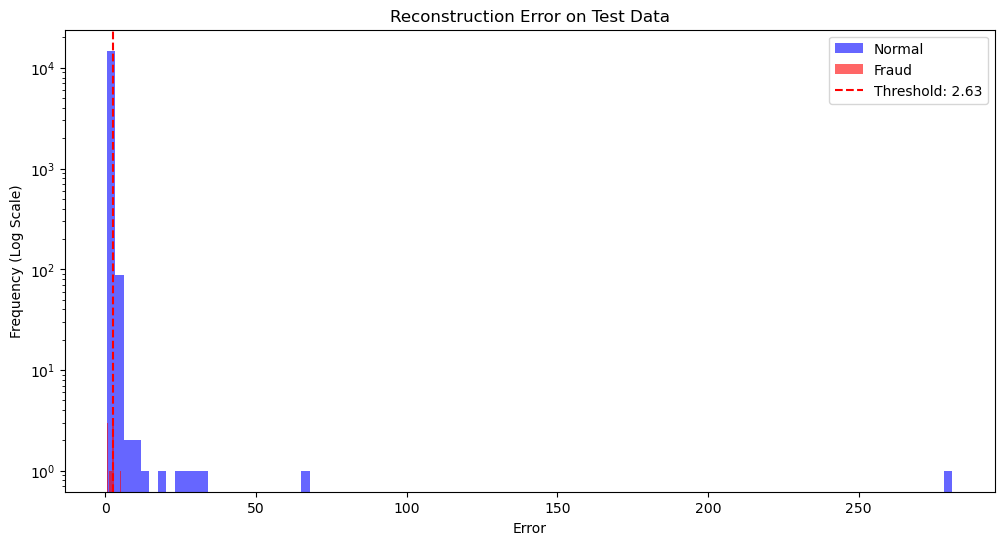

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
import xgboost as xgb
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow_addons as tfa


# Create the autoencoder model
model = keras.Sequential(
    [
        keras.Input(shape=(20,)),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(20, activation="linear"),
    ]
)

optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)
model.compile(loss="mse", optimizer=optimizer)

model.fit(train_x, train_x, batch_size=128, epochs=20, validation_data=(test_x, test_x))

# Calculate reconstruction error
train_predictions = model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)

test_predictions = model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

# Use 99.7th percentile of train error as initial threshold
threshold = np.percentile(train_error, 99.0)
print(f"Threshold: {threshold}")

# Identify anomalies based on the threshold
test_predictions_class = [1 if e > threshold else 0 for e in test_error]

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
train_x_resampled, train_y_resampled = smote.fit_resample(train_x, train_y)

# Train an XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42)
xgb_model.fit(train_x_resampled, train_y_resampled)

# Predict using the XGBoost model
xgb_predictions = xgb_model.predict(test_x)

# Evaluate the ensemble model


# Ensemble Decision: Require both models to agree on fraud
ensemble_predictions = [1 if auto == 1 and xgb == 1 else 0 for auto, xgb in zip(test_predictions_class, xgb_predictions)]

# Evaluation of the ensemble model
print("Classification Report for the Ensemble Model:")
print(classification_report(test_y, ensemble_predictions))

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction Error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

Epoch 1/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9019 - val_loss: 0.9114
Epoch 2/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 4/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 5/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 6/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 7/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 8/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 9/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114
Epoch 10/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83dad72680>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Threshold: 4.114844144870737


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83d7b61c60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Classification Report for the Ensemble Model:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     14870
         1.0       0.26      0.04      0.07       130

    accuracy                           0.99     15000
   macro avg       0.63      0.52      0.53     15000
weighted avg       0.99      0.99      0.99     15000



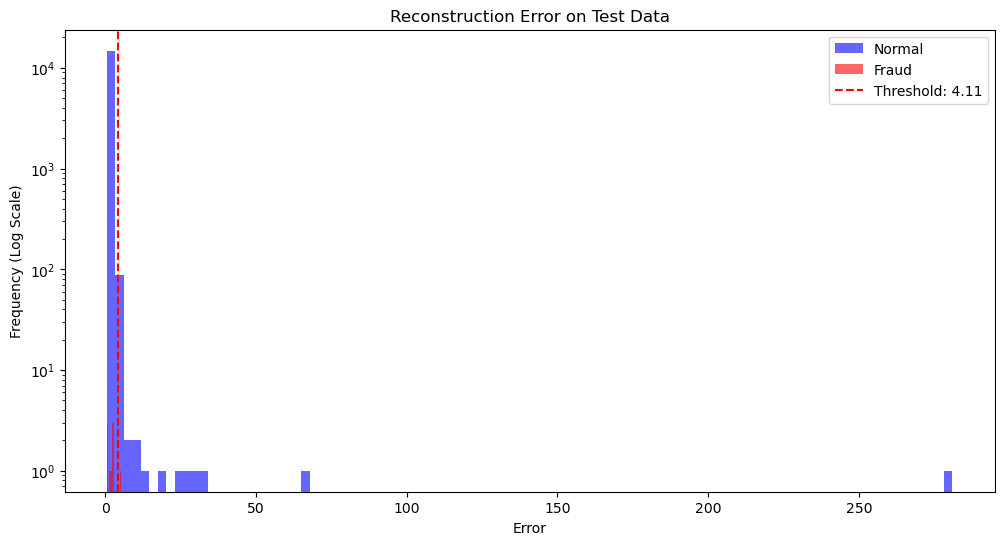

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report
import xgboost as xgb

# Create the autoencoder model
model = keras.Sequential([
    keras.Input(shape=(20,)),
    Dense(128, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(128, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(20, activation="linear"),
])

# Adjust the learning rate
optimizer = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.01)
model.compile(loss="mse", optimizer=optimizer)

# Introduce early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(train_x, train_x, batch_size=128, epochs=50, validation_data=(test_x, test_x), callbacks=[early_stopping])

# Calculate reconstruction error
train_predictions = model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)

test_predictions = model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

# Use 99.5th percentile of train error as initial threshold
threshold = np.percentile(train_error, 99.5)
print(f"Threshold: {threshold}")

# Identify anomalies based on the threshold
test_predictions_class = [1 if e > threshold else 0 for e in test_error]

# Apply ADASYN for better handling of imbalanced data
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
train_x_resampled, train_y_resampled = adasyn.fit_resample(train_x, train_y)

# Train an XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42)
xgb_model.fit(train_x_resampled, train_y_resampled)

# Predict using the XGBoost model
xgb_predictions = xgb_model.predict(test_x)

# Ensemble Decision: Require both models to agree on fraud
ensemble_predictions = [1 if auto == 1 and xgb == 1 else 0 for auto, xgb in zip(test_predictions_class, xgb_predictions)]

# Evaluation of the ensemble model
print("Classification Report for the Ensemble Model:")
print(classification_report(test_y, ensemble_predictions))

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction Error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

Epoch 1/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9012 - val_loss: 0.9114 - lr: 1.0000e-04
Epoch 2/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114 - lr: 1.0000e-04
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114 - lr: 1.0000e-04
Epoch 4/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114 - lr: 1.0000e-04
Epoch 5/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114 - lr: 1.0000e-04
Epoch 6/50
267/274 [============================>.] - ETA: 0s - loss: 0.9008
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114 - lr: 1.0000e-04
Epoch 7/50
274/274 [==============================] - 1s 3ms/step - loss: 0.9000 - val_loss: 0.9114 - lr: 5.0000e-05
Epoch 8/50
274/274 [===================

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83dc32e680>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83dc32e680>
Traceb

Optimal Threshold: 2.039251099586304
Classification Report for the Ensemble Model:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14870
         1.0       0.63      0.43      0.51       130

    accuracy                           0.99     15000
   macro avg       0.81      0.71      0.75     15000
weighted avg       0.99      0.99      0.99     15000



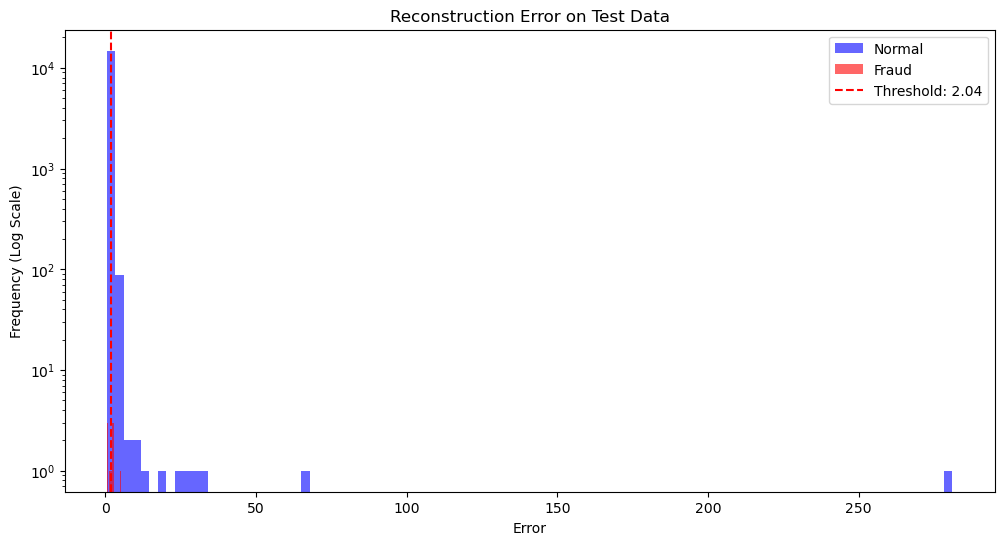

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import tensorflow_addons as tfa

# 1. Adding a ReduceLROnPlateau callback to reduce the learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

# 2. Introducing early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the autoencoder model
model = keras.Sequential([
    keras.Input(shape=(20,)),
    Dense(128, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(128, activation=keras.layers.LeakyReLU(alpha=0.01)),
    Dropout(0.3),
    Dense(20, activation="linear"),
])

# Adjust the learning rate
optimizer = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.01)
model.compile(loss="mse", optimizer=optimizer)

# Train the model
model.fit(train_x, train_x, batch_size=128, epochs=50, validation_data=(test_x, test_x), callbacks=[early_stopping, lr_reduction])

# Calculate reconstruction error
train_predictions = model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)
test_predictions = model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

# 3. Adjusting the threshold based on the F1 score
thresholds = np.linspace(0.0, np.max(train_error), 1000)
f1_scores = [f1_score(test_y, [1 if e > threshold else 0 for e in test_error]) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {optimal_threshold}")

# Identify anomalies based on the optimal threshold
test_predictions_class = [1 if e > optimal_threshold else 0 for e in test_error]

# Apply ADASYN for better handling of imbalanced data
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
train_x_resampled, train_y_resampled = adasyn.fit_resample(train_x, train_y)

# 4. Adjusting the XGBoost parameters
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=4, scale_pos_weight=10, random_state=42)
xgb_model.fit(train_x_resampled, train_y_resampled)

# Predict using the XGBoost model
xgb_predictions = xgb_model.predict(test_x)

# Ensemble Decision: Require both models to agree on fraud
ensemble_predictions = [1 if auto == 1 and xgb == 1 else 0 for auto, xgb in zip(test_predictions_class, xgb_predictions)]

# Evaluation of the ensemble model
print("Classification Report for the Ensemble Model:")
print(classification_report(test_y, ensemble_predictions))

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Threshold: {optimal_threshold:.2f}')
plt.title('Reconstruction Error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

Epoch 1/50
274/274 [==============================] - 2s 4ms/step - loss: 0.7493 - val_loss: 0.3449
Epoch 2/50
274/274 [==============================] - 1s 3ms/step - loss: 0.3909 - val_loss: 0.1491
Epoch 3/50
274/274 [==============================] - 1s 3ms/step - loss: 0.2895 - val_loss: 0.1117
Epoch 4/50
274/274 [==============================] - 1s 3ms/step - loss: 0.2453 - val_loss: 0.0848
Epoch 5/50
274/274 [==============================] - 1s 4ms/step - loss: 0.2183 - val_loss: 0.0644
Epoch 6/50
274/274 [==============================] - 1s 4ms/step - loss: 0.1969 - val_loss: 0.0535
Epoch 7/50
274/274 [==============================] - 1s 3ms/step - loss: 0.1823 - val_loss: 0.0466
Epoch 8/50
274/274 [==============================] - 1s 4ms/step - loss: 0.1703 - val_loss: 0.0424
Epoch 9/50
274/274 [==============================] - 1s 4ms/step - loss: 0.1646 - val_loss: 0.0368
Epoch 10/50
274/274 [==============================] - 1s 3ms/step - loss: 0.1556 - val_loss: 0.0352

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83d7225240>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Optimal Threshold: 0.01532394383439392


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f83d7225240>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Classification Report for the Ensemble Model:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14870
         1.0       0.71      0.83      0.76       130

    accuracy                           1.00     15000
   macro avg       0.85      0.91      0.88     15000
weighted avg       1.00      1.00      1.00     15000



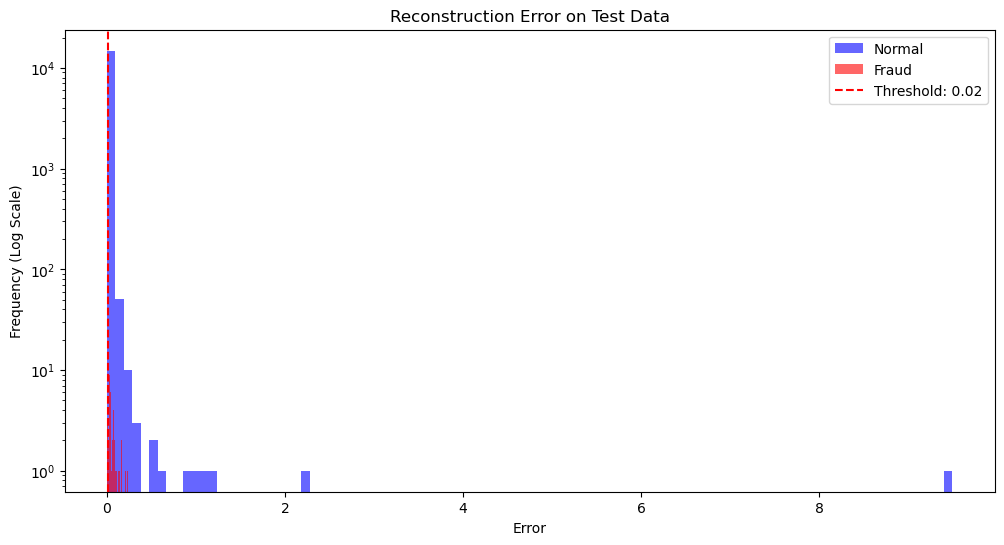

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, LeakyReLU, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.metrics import classification_report, f1_score
import xgboost as xgb

# Define the autoencoder model
input_layer = Input(shape=(20,))
encoder = Dense(256)(input_layer)
encoder = LeakyReLU(alpha=0.01)(encoder)
encoder = Dropout(0.3)(encoder)
encoder = Dense(128)(encoder)
encoder = LeakyReLU(alpha=0.01)(encoder)
encoder = Dropout(0.3)(encoder)
encoder = Dense(64)(encoder)
encoder = LeakyReLU(alpha=0.01)(encoder)

decoder = Dense(128)(encoder)
decoder = LeakyReLU(alpha=0.01)(decoder)
decoder = Dropout(0.3)(decoder)
decoder = Dense(256)(decoder)
decoder = LeakyReLU(alpha=0.01)(decoder)
decoder = Dropout(0.3)(decoder)
output_layer = Dense(20, activation="linear")(decoder)

model = Model(inputs=input_layer, outputs=output_layer)

# Adjust the learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="mse", optimizer=optimizer)

# Introduce early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(train_x, train_x, batch_size=128, epochs=50, validation_data=(test_x, test_x), callbacks=[early_stopping])

# Calculate reconstruction error
train_predictions = model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)

test_predictions = model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

# Use 85th percentile of train error as initial threshold
threshold = np.percentile(train_error, 88)

# Determine threshold based on precision-recall tradeoff
#precisions, recalls, thresholds = precision_recall_curve(test_y, test_error)
#threshold = thresholds[np.argmax(precisions >= 0.65)] # You can adjust this value based on your requirements
#print(f"Threshold: {threshold}")

'''thresholds = np.linspace(0.0, np.max(train_error), 1000)
f1_scores = [f1_score(test_y, [1 if e > threshold else 0 for e in test_error]) for threshold in thresholds]
threshold = thresholds[np.argmax(f1_scores)]'''
print(f"Optimal Threshold: {threshold}")

# Identify anomalies based on the threshold
test_predictions_class = [1 if e > threshold else 0 for e in test_error]

# Apply ADASYN for better handling of imbalanced data
adasyn = ADASYN(sampling_strategy='auto', random_state=42)
train_x_resampled, train_y_resampled = adasyn.fit_resample(train_x, train_y)

# Use SMOTE for resampling
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#train_x_resampled, train_y_resampled = smote.fit_resample(train_x, train_y)

# Train an XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=5, random_state=42)
xgb_model.fit(train_x_resampled, train_y_resampled)

# Predict using the XGBoost model
xgb_predictions = xgb_model.predict(test_x)

# Ensemble Decision: Require both models to agree on fraud
ensemble_predictions = [1 if auto == 1 and xgb == 1 else 0 for auto, xgb in zip(test_predictions_class, xgb_predictions)]

# Evaluation of the ensemble model
print("Classification Report for the Ensemble Model:")
print(classification_report(test_y, ensemble_predictions))

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction Error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()


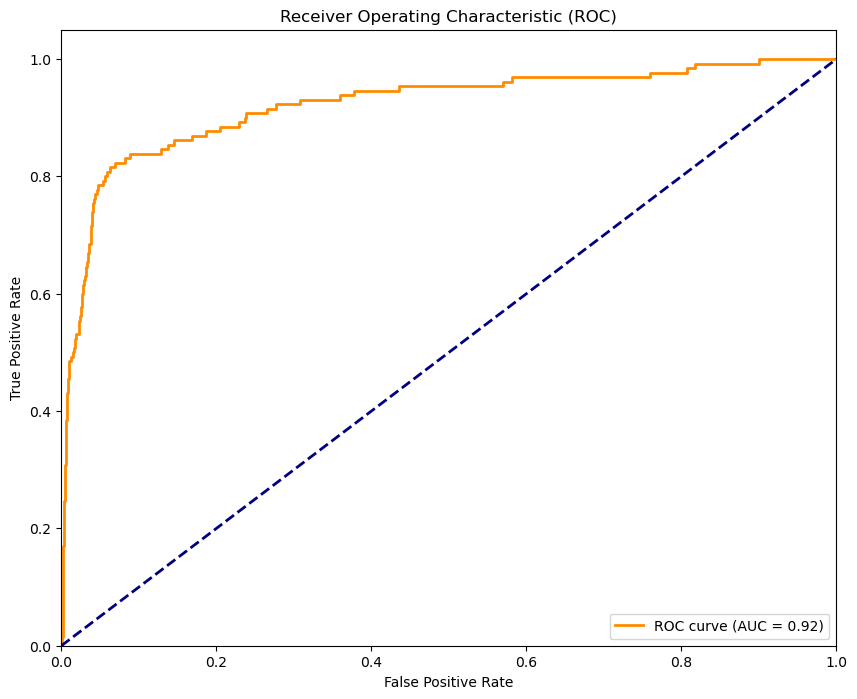

In [67]:
from sklearn.metics import roc_curve, auc
r
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, test_error)

# Calculate the AUC (area under the curve)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()